In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import optax
import jax
from jax import vmap
import jax.numpy as jnp
from evosax.strategies.open_nes import init_strategy, ask, tell
from evosax.utils import z_score_fitness, rank_shaped_fitness


def quadratic_fitness(w):
    fit = jnp.sum(jnp.square(w - jnp.array([0.5, 0.1, -0.3])))
    return fit

batch_fitness = vmap(quadratic_fitness, 0)

population_size = 50  
sigma = 0.25
lrate = 0.01
rng = jax.random.PRNGKey(0)

In [2]:
n_dim = 3
mean_init = jnp.zeros((n_dim, ))

opt = optax.adam(lrate)
opt_state = opt.init(mean_init)

In [3]:
rng = jax.random.PRNGKey(0)
num_generations = 1000
params, memory = init_strategy(n_dim, lrate, mean_init,
                               population_size)
fit = []
for g in range(num_generations):
    # Explicitly handle random number generation
    rng, rng_input = jax.random.split(rng)

    # Ask for the next generation population to test
    x, memory = ask(rng_input, params, memory)
    # Evaluate the fitness of the generation members
    #fitness = batch_rosenbrock(x, 1, 100) 
    fitness = batch_fitness(x)
    fit.append(fitness.min())
    fitness = z_score_fitness(fitness)
    #x, fitness = rank_shaped_fitness(x, fitness)
    # Tell/Update the CMA-ES with newest data points
    memory, opt_state = tell(x, fitness, params, memory, opt_state)
    

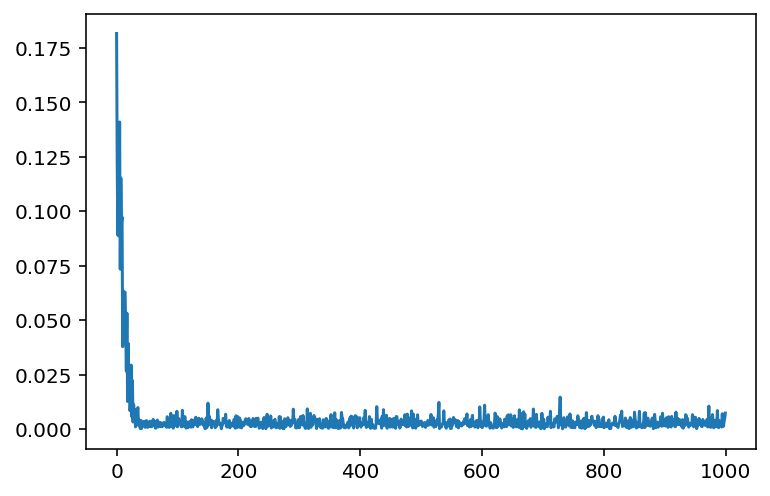

In [4]:
import matplotlib.pyplot as plt
plt.plot(fit)

In [ ]:
# Old snippets with explicit Fisher inverse - Problem with vector outer product
# and rank deficiency when trying to do inverse!
def tell_nas_strategy(x, fitness, params, memory, opt, opt_state):
    """ Update the surrogate ES model. """
    memory["generation"] = memory["generation"] + 1

    # Get REINFORCE-style gradient for each sample
    log_grads = batch_grad_logpdf(x, memory["search_params"])
    # Weight grads by fitness/fitness shaping-rank + Fischer Estimator
    fischer_weighted_grads = {}
    for k, l_grad in log_grads.items():
        # Weight grads by fitness
        weighted_log_grads = jnp.mean(fitness[:, None, None]*l_grad, axis=0)
        # Compute unweighted mean for Fischer approximation
        mean_log_grads = jnp.mean(l_grad, axis=0)
        print(mean_log_grads.shape)
        outer_product = mean_log_grads @ mean_log_grads.T
        # Compute the Fischer matrix approximation
        fischer_inverse = jnp.linalg.inv(outer_product)
        fischer_weighted_grads[k] = (-1.*fischer_inverse @ weighted_log_grads)
    # Perform natural gradient update using optax - Flip grad sign for min!
    updates, opt_state = opt.update(fischer_weighted_grads, opt_state)
    new_params = optax.apply_updates(memory["search_params"], updates)
    memory["search_params"] = new_params
    return memory, opt_state


def grad_gauss_logpdf(x, params):
    """ Obtain grad log pi for multivariate Gaussian case. """
    def gauss_logpdf(x, params):
        return logpdf(x, params["mean"].squeeze(), params["C"])
    return grad(gauss_logpdf, argnums=(1))(x, params)

def loss_logpdf(x, weight, params):
    weighted_logprobs = batch_grad_logpdf(x, weight, params)
    return - weighted_logprobs.mean()


def weighted_gauss_logpdf(x, weight, params):
    """ Obtain grad log pi for multivariate Gaussian case. """
    def gauss_logpdf(x, params):
        return logpdf(x, params["mean"].squeeze(), params["C"])
    return gauss_logpdf(x, params) * weight


batch_grad_logpdf = vmap(weighted_gauss_logpdf, in_axes=(0, 0, None))